<>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\shale\AppData\Local\Temp\ipykernel_50864\19226989.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if skip_con is not 0:


273
tensor([[-8.5076e-11,  3.8051e-11, -1.2001e-09,  ...,  0.0000e+00,
         -0.0000e+00, -0.0000e+00]])
32000
The model has 159,160 trainable parameters
<generator object data_generation at 0x0000020ED7645CC0>
here_1


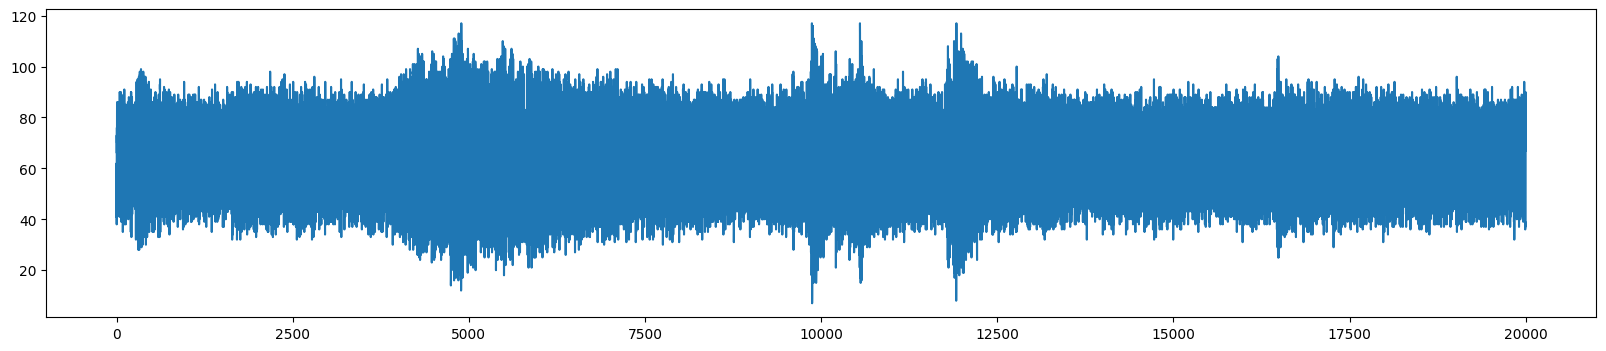

In [20]:
import torchaudio
import random
from datasets import load_dataset
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import ModuleList
from IPython.display import Audio
from torch.autograd import Variable
%matplotlib inline 

device = "cuda" if torch.cuda.is_available() else "cpu"


class OneHot(nn.Module):
    def __init__(self, MU):
        super(OneHot, self).__init__()
        self.MU = MU
        self.ones = torch.sparse.torch.eye(MU).to(device)

    def forward(self, x):
        x = x.to(device)
        return Variable(self.ones.index_select(0, x.data)).to(device)

    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.MU)


class Wavenet(nn.Module):
    def __init__(self, dilation_depth, n_blocks, n_dil_channnels, n_residual_channels, n_skip_channels, n_category,
                 kernel_size):
        super(Wavenet, self).__init__()
        self.dilation_depth = dilation_depth
        self.n_blocks = n_blocks
        self.n_dil_channnels = n_dil_channnels
        self.n_residual_channels = n_residual_channels
        self.n_skip_channels = n_skip_channels
        self.n_category = n_category
        self.kernel_size = kernel_size
        self.One_hot = OneHot(n_category)

        ###Building the model###
        self.dilations = [2 ** i for i in range(dilation_depth)] * n_blocks

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()

        ##creating first channels##
        self.input_convs = nn.Conv1d(in_channels=self.n_category, out_channels=self.n_residual_channels, kernel_size=1)
        ###Creating wavenet blocks stacks###
        for d in self.dilations:
            self.filter_convs.append(
                nn.Conv1d(in_channels=n_residual_channels, out_channels=n_dil_channnels, kernel_size=kernel_size,
                          dilation=d))
            self.gate_convs.append(
                nn.Conv1d(in_channels=n_residual_channels, out_channels=n_dil_channnels, kernel_size=kernel_size,
                          dilation=d))
            self.residual_convs.append(
                nn.Conv1d(in_channels=n_dil_channnels, out_channels=n_residual_channels, kernel_size=1))
            self.skip_convs.append(nn.Conv1d(in_channels=n_dil_channnels, out_channels=n_skip_channels, kernel_size=1))
        ##post convoluions
        self.post_conv1 = nn.Conv1d(in_channels=n_skip_channels, out_channels=n_skip_channels, kernel_size=1)
        self.post_conv2 = nn.Conv1d(in_channels=n_skip_channels, out_channels=n_category, kernel_size=1)

    def forward(self, x):
        x.to(device)
        x = self.One_hot(x).unsqueeze(0).transpose(1, 2)
        ### shape of x [batch_size, n_category, seq_len]
        x = self.input_convs(x)  ### shape [batch_size, n_category, n_residual]
        skip_con = 0
        for i in range(self.dilation_depth * self.n_blocks):
            dilation = self.dilations[i]
            res = x
            filter = self.filter_convs[i](x)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](x)
            gate = torch.sigmoid(gate)
            x = filter * gate

            s = self.skip_convs[i](x)
            if skip_con is not 0:
                skip_con = skip_con[:, :, -s.size(2):]
            skip_con = s + skip_con
            x = self.residual_convs[i](x)
            x = x + res[:, :, dilation * (self.kernel_size - 1):]
        x = torch.relu(skip_con)
        x = torch.relu(self.post_conv1(x))
        x = self.post_conv2(x)
        return torch.transpose(x.squeeze(0), 0, 1)

    ###Function to generate samples###
    def generate(self, input, num_samples=100):
        gen_list = input.data.tolist()
        for _ in range(num_samples):
            x = Variable(torch.LongTensor(gen_list[-sum(self.dilations) - 1:]))
            y = self.forward(x)
            _, i = y.max(dim=1)
            gen_list.append(i.data.tolist()[-1])
        return gen_list


def mulaw_quantize(x, qc):
    assert isinstance(x, torch.Tensor), 'mu_law_encoding expects a Tensor'
    mu = qc - 1
    if not x.is_floating_point():
        x = x.to(torch.float)
    mu = torch.tensor(mu, dtype=x.dtype)
    x_mu = torch.sign(x) * torch.log1p(mu *
                                       torch.abs(x)) / torch.log1p(mu)
    x_mu = ((x_mu + 1) / 2 * mu + 0.5).to(torch.int64)
    return x_mu


def inv_mulaw_quantize(x_mu, quantization_channels=256, device=device):
    mu = quantization_channels - 1.
    if isinstance(x_mu, np.ndarray):
        x = ((x_mu) / mu) * 2 - 1.
        x = np.sign(x) * (np.exp(np.abs(x) * np.log1p(mu)) - 1.) / mu
    elif isinstance(x_mu, (torch.Tensor, torch.LongTensor)):
        if isinstance(x_mu, (torch.LongTensor, torch.cuda.LongTensor)):
            x_mu = x_mu.float()
        if device == "cuda":
            mu = (torch.FloatTensor([mu]))
        else:
            mu = torch.FloatTensor([mu])
        x = ((x_mu) / mu) * 2 - 1.
        x = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1.) / mu
    return x


def data_generation(data, fr, seq_len_segment, mu, device=device):
    max, _ = torch.max(data, 1, keepdim=True)
    min, _ = torch.min(data, 1, keepdim=True)
    comparison = max > torch.abs(min)
    if torch.all(comparison):
        data = torch.div(data, max)
    else:
        # abs_min_vals = torch.abs(min)
        data = torch.div(data, abs(min))
    while True:
        start = np.random.randint(0, data.shape[1] - seq_len_segment)
        ys = data[:, start:start + seq_len_segment]
        ys = mulaw_quantize(ys, mu)
        ys = ys.squeeze(0)
        yield ys.to(device)


# Load dataset
hsn = load_dataset('DBD-research-group/BirdSet', 'HSN')

subset_percentage = 0.05  # 25%
subset_indices = random.sample(range(len(hsn['train'])), int(len(hsn['train']) * subset_percentage))
hsn = hsn['train'].select(subset_indices)
print(len(subset_indices))


def preprocess(batch):
    audio_tensors = []
    audio, _ = torchaudio.load(batch['filepath'])
    return audio, _


#hsn = hsn.map(preprocess, batched=True, batch_size=1)
data, sr = preprocess(hsn[0])
print(data)
print(sr)

dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = 128
kernel_size = 2
model = Wavenet(dilation_depth, n_blocks, n_dilation_channels, n_residual_channels, n_skip_channels, n_category,
                kernel_size)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')
model.to(device)
model.eval()

g = data_generation(data, sr, mu=128, seq_len_segment=20000, device=device)
print(g)

u = next(g)
u = u.data.tolist()
plt.figure(figsize=[20, 4])
plt.plot(u)

y = np.array(u)
y = inv_mulaw_quantize(y, 128)

#import soundfile as sf
#output_file = 'output_audio.wav'
#sf.write(output_file, y, sr)

In [ ]:
from torch.optim import Adam

optimizer = Adam(params=model.parameters(), lr=0.01, eps=1e-8)
loss_function = nn.CrossEntropyLoss()

batch_size = 64
training_loss = []
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    train_loss = 0.0
    for _ in range(batch_size):
        optimizer.zero_grad()
        batch = next(g)
        x = batch[:-1]
        x = x.to(device)
        logits = model(x)
        t = logits.size(0)
        loss = loss_function(logits, batch[-t:])
        train_loss = train_loss + loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_loss / batch_size
    training_loss.append(loss)
    # # monitor at 100 epochs interval
    if epoch % 100 == 0:
        print('epoch {}/{}, loss {}'.format(epoch, epochs, train_loss))